<a href="https://colab.research.google.com/github/JasChia/LSTM-MM/blob/main/Full_LSTM_MM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modeling Microbiota Notebook
This is the notebook with the full code utilized within the paper Modeling Microbiota: Using LSTM to Study Vaginal Dynamics.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from torch.utils.data import Dataset
import math
import collections
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader,TensorDataset
from google.colab import drive
import matplotlib.cm as cm
import os
import sys
import pickle
import zipfile

##Model Definition
Defining the model along with all helper functions necessary to train and test the model and obtain SHAP values.

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, num_layers=1, dropout=0.5, batch_size=1, output_size=1):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.SM = nn.Sigmoid()

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(-1,len(input_seq[0]),len(input_seq[0][0])), self.hidden)
        pred = self.linear(lstm_out.view(-1,len(lstm_out[0]),len(lstm_out[0][0])))[:,-1]
        pred = self.SM(pred)
        return pred

def reset_weights(m):
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def train_model(model, train_dataloader, loss_function1, optimizer):
    model.train()
    sum_loss = 0
    for i in range(0,len(trainingData),batch_size):
        seq,labels = next(iter(train_dataloader))
        seq=seq.float().to(device)
        labels=labels.float().to(device)
        if(len(seq)==batch_size):
            model.hidden = (torch.zeros(layers, batch_size, model.hidden_layer_size).to(device),
                            torch.zeros(layers, batch_size, model.hidden_layer_size).to(device))
            y_pred = model(seq)
            single_loss = loss_function1(y_pred, labels)
            optimizer.zero_grad()
            single_loss.backward()
            optimizer.step()
            sum_loss += single_loss.item()
    avg_loss = sum_loss/len(trainingData)
    return avg_loss

def test_model(model_in, test_inputs, fut_pred):
    model_in.eval()
    new_test_inputs = test_inputs.copy()
    for j in range(fut_pred):
        seq = torch.FloatTensor(new_test_inputs[-train_window:]).to(device)
        seq = seq.reshape(1,len(seq),len(seq[0]))
        with torch.no_grad():
            model_in.hidden = (torch.zeros(layers,1,model_in.hidden_layer_size).to(device),
                               torch.zeros(layers,1,model_in.hidden_layer_size).to(device))
            nextstep=model_in(seq).tolist()
            new_test_inputs.append(nextstep[0])

    output = new_test_inputs[-fut_pred:]
    return torch.FloatTensor(output)

def full_train(num_channels,hsize,layers,dropout,batch_size,LR,num_epochs,train_dataloader,test_in,tensor_true_test_data):
    print(f'hsize:{hsize}       layers:{layers}       num_epochs:{num_epochs}       dropout:{dropout}      batch_size:{batch_size}       lr:{LR}')
    tensor_test_in = torch.FloatTensor(test_in).view(-1,num_channels).to(device)
    test_in_local = copy.deepcopy(test_in)
    tensor_test_in_local = torch.FloatTensor(test_in_local).view(-1,num_channels).to(device)
    model = LSTM(input_size=num_channels,hidden_layer_size=hsize,num_layers=layers,output_size=num_channels,dropout=dropout,batch_size=batch_size).to(device)
    model.apply(reset_weights)
    optimizer = torch.optim.Adam(model.parameters(),lr=LR)
    optimizer.state = collections.defaultdict(dict)
    fut_pred = len(tensor_true_test_data)
    best_loss = 9999.9

    for name, param in model.named_parameters():
        if 'bias' in name:
            nn.init.constant_(param,0.0)
            start = int(len(param)/4)
            end = int(len(param)/2)
            param.data[start:end].fill_(1.)
        elif 'weight' in name:
            nn.init.orthogonal_(param)

    loss_function1 = nn.BCELoss().to(device)

    for i in range(num_epochs):
        avg_loss = train_model(model, train_dataloader, loss_function1, optimizer)
        #Obtain testing loss every 25 epochs and compare to find the best model
        if i%25 == 1 or i==num_epochs-1:
            ap = test_model(model, test_in_local, fut_pred).view(-1,num_channels).to(device)
            test_loss = loss_function1(ap, tensor_true_test_data)
            print(f'Epoch:{i}       TestLoss1:{test_loss}      TrainLoss:{avg_loss}')
            if test_loss.item() < best_loss and i>300:
                best_loss = test_loss.item()
                best_i = i
                best_ap = ap.detach().clone()
                model_clone = LSTM(input_size=num_channels,hidden_layer_size=hsize,num_layers=layers,output_size=num_channels,dropout=dropout,batch_size=batch_size).to(device)
                model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    best_prediction = best_ap#.tolist()

    del loss_function1, optimizer, model
    torch.cuda.empty_cache()

    return best_prediction, best_i, model_clone, best_loss

class HidePrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def shap_val(model, train_X, test_X):
    #test_X is expected to be None because the training data is the one being explained
    #train_X should be a tensor, DoubleTensor or FloatTensor are both fine, of the training data of shape (#samples, #timesteps, #features)
    #model is the model
    #test_X should be None (unless explaining a different data or a full training data subset, then it should be of shape (#samples, #timesteps, #features) as a double or float tensor)
    test_model = model.eval()
    train_X = train_X.type(torch.FloatTensor).to(device) #Ensure data type is float tensor
    test_model.hidden = (torch.zeros(layers,train_X.shape[0],model.hidden_layer_size).to(device),
                         torch.zeros(layers,train_X.shape[0],model.hidden_layer_size).to(device))

    explainer = shap.DeepExplainer(test_model, train_X)
    if test_X is not None:
        test_X = test_X.type(torch.FloatTensor).to(device)

        test_model.hidden = (torch.zeros(layers,train_X.shape[0] * 2,model.hidden_layer_size).to(device),
                            torch.zeros(layers,train_X.shape[0] * 2,model.hidden_layer_size).to(device))
        # explaining each prediction requires 2 * background dataset size runs
        test_model.train()
        shap_values = explainer.shap_values(test_X)
    
    else:
        test_model.hidden = (torch.zeros(layers,train_X.shape[0] * 2,model.hidden_layer_size).to(device),
                            torch.zeros(layers,train_X.shape[0] * 2,model.hidden_layer_size).to(device))
        test_model.train()
        with HidePrints():
            shap_values = explainer.shap_values(train_X)
    return explainer, shap_values



##Data Preparation
Preparing the training and test data using the train_test_sequences.pickle file produced from running the data parsing file on VMBData_clean.xlsx. The GitHub repository is downloaded to access the dataset.

In [3]:
!wget --no-check-certificate \
    "https://github.com/JasChia/LSTM-MM/archive/refs/heads/main.zip" \
    -O "/tmp/LSTM_MM.zip"


zip_ref = zipfile.ZipFile('/tmp/LSTM_MM.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

%cd /tmp/LSTM-MM-main/Data&Models

--2022-09-15 14:50:09--  https://github.com/JasChia/LSTM-MM/archive/refs/heads/main.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/JasChia/LSTM-MM/zip/refs/heads/main [following]
--2022-09-15 14:50:09--  https://codeload.github.com/JasChia/LSTM-MM/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/LSTM_MM.zip’

/tmp/LSTM_MM.zip        [   <=>              ]   6.83M  12.2MB/s    in 0.6s    

2022-09-15 14:50:10 (12.2 MB/s) - ‘/tmp/LSTM_MM.zip’ saved [7165550]

/tmp/LSTM-MM-main/Data&Models


In [4]:
def setup_testing(training_seqs, testing_seqs, testing_traj_index):
    testing_seq = testing_seqs[testing_traj_index]
    test_IDs = []
    for i in range(len(testing_seq)):
        temp = ''.join(testing_seq[i,0:2])
        test_IDs.append(temp+str(testing_seq[i,2]))
    filtered_training_seqs = []
    for training_seq in training_seqs:
        flag = True
        train_IDs = []
        for i in range(len(training_seq)):
            temp = ''.join(training_seq[i,0:2])
            train_IDs.append(temp+str(training_seq[i,2]))
        overlap = list(set(train_IDs).intersection(set(test_IDs)))
        if len(overlap)==0:
            filtered_training_seqs.append(training_seq)

    return filtered_training_seqs, testing_seq

blastT_labels = ['L. crispatus',
 'L. iners',
 'L. gasseri',
 'L. jensenii',
 'L. other',
 'Gardnerella spp',
 'Streptococcus spp', 
 'Atopobium spp',
 'Prevotella spp',
 'Bergeyella spp',
 'Corynebacterium spp',
 'Finegoldia spp',
 'Sneathia spp',
 'Dialister spp',
 'Other']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

#Loading training data
with open('train_test_sequences.pickle','rb') as f:
    all_training_sequences, all_testing_sequences = pickle.load(f)

# Pick testing traj and remove training ones w overlap to avoid overfit
testing_traj_ind = 0
filtered_training_seqs, testing_seq = setup_testing(all_training_sequences, all_testing_sequences, testing_traj_ind)

print("Training set:", len(filtered_training_seqs), "trajectories")

# remove metadata cols
np_filtered_training_seqs = np.array(filtered_training_seqs)[:, :, 3:]
testing_seq = np.array(testing_seq[:, 3:], dtype=float)

# Flatten to 2d array, rescale, unflatten
# Shape is (n_trajectories, n_timepoints, n_features)
np_filtered_training_seqs_flatten = np.reshape(np_filtered_training_seqs, ((len(filtered_training_seqs))*15, 15))
scaler = MinMaxScaler()
np_filtered_training_seqs_flatten = scaler.fit_transform(np_filtered_training_seqs_flatten)
np_filtered_training_seqs = np.reshape(np_filtered_training_seqs_flatten, ((len(filtered_training_seqs)), 15, 15))# Now create Dataloader
num_traj, num_timesteps, num_inputs, = np_filtered_training_seqs.shape
# last timestep is label data
num_timesteps += -1
tensor_training_data = torch.empty((num_traj, num_timesteps, num_inputs),dtype=float)
tensor_label_data = torch.empty((num_traj, num_inputs),dtype=torch.float)

for i in range(num_traj):
    tensor_training_data[i, :, :] = torch.FloatTensor(np_filtered_training_seqs[i, :-1, :])
    tensor_label_data[i] = torch.FloatTensor(np_filtered_training_seqs[i, -1, :])

print('Training Size', tensor_training_data.shape)
print('Training Label Size:', tensor_label_data.shape)

Device: cuda
Training set: 413 trajectories
Training Size torch.Size([413, 14, 15])
Training Label Size: torch.Size([413, 15])


## Training loop

In [5]:
ensemble_size = 1 #Number of restarts
num_channels = 15
num_timesteps = num_timesteps
train_window = 14

trainingData = tensor_training_data
trainingData2 = TensorDataset(tensor_training_data, tensor_label_data)

test_in = testing_seq[0:14, :].tolist()
tensor_true_test_in = torch.FloatTensor(testing_seq[0:14, :]).to(device)
tensor_true_test_data = torch.FloatTensor(testing_seq[14:, :]).to(device)

total_tloss = 0
for z in range(ensemble_size):
    
    hparamdict = {'hsize': 51,
   'layers': 3,
   'batch_size': 32,
   'num_epochs': 700,
   'lr': 0.0001,
   'dropout': 0.6}

    hsize = hparamdict['hsize']
    layers = hparamdict['layers']
    LR = hparamdict['lr']
    batch_size = hparamdict['batch_size']
    num_epochs = hparamdict['num_epochs']
    dropout = hparamdict['dropout']
    
    print('Hyperparameters:', hparamdict)
    
    train_dataloader = DataLoader(trainingData2, batch_size=batch_size, shuffle=True)
    best_prediction, bpred_epoch, best_model, test_loss = full_train(num_channels,hsize,layers,dropout,batch_size,LR,
                                         num_epochs,train_dataloader,test_in,
                                         tensor_true_test_data)
    total_tloss += test_loss
    print(f'Run: {z+1}    Test Loss: {test_loss}    Restart: {z+1}    Best Epoch: {bpred_epoch}')
    if z == ensemble_size:
        avg_tloss = total_tloss/(z+1)
        print('Average Test Loss:', avg_tloss)

Hyperparameters: {'hsize': 51, 'layers': 3, 'batch_size': 32, 'num_epochs': 700, 'lr': 0.0001, 'dropout': 0.6}
hsize:51       layers:3       num_epochs:700       dropout:0.6      batch_size:32       lr:0.0001
Epoch:1       TestLoss1:0.8270836472511292      TrainLoss:0.02609113602026323
Epoch:26       TestLoss1:0.19921450316905975      TrainLoss:0.008445862166529417
Epoch:51       TestLoss1:0.18136535584926605      TrainLoss:0.006571122000927498
Epoch:76       TestLoss1:0.17890240252017975      TrainLoss:0.0057222686220889515
Epoch:101       TestLoss1:0.17927904427051544      TrainLoss:0.005416573140292133
Epoch:126       TestLoss1:0.1857878565788269      TrainLoss:0.0053088694233582616
Epoch:151       TestLoss1:0.1768292486667633      TrainLoss:0.005125051513133846
Epoch:176       TestLoss1:0.17832805216312408      TrainLoss:0.005362031210132719
Epoch:201       TestLoss1:0.17423899471759796      TrainLoss:0.0049165804435208115
Epoch:226       TestLoss1:0.16586606204509735      TrainLos

## Plot best fit
This can be used to generate plots to visually see the fit of the LSTM.

In [6]:
def plot_best_fit(true_data, prediction, model_pred_color, true_data_color, idx, labels, save, save_dir):
    #idx is a list of the index of the species
    #idx of the prediction and labels should correspond
    #prediction should be the output of the testing scheme
    #model_pred_color and true_data_color are both lists that should correspond to the color you want for each species plotted
    #true_data should be shape (timesteps, species)
    assert len(model_pred_color) == len(true_data_color) == len(idx), 'Make sure the lists of colors and indexes are the same size'
    assert len(true_data[0]) == len(labels), 'Make sure the size of the features and labels are the same shape'
    plt.close()
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    plt.rcParams['axes.linewidth'] = 3
    plt.rcParams['figure.figsize'] = [8, 6]
    pred_labels = ' prediction'
    best_pred = torch.clone(prediction).detach()
    fig2, ax2 = plt.subplots()
    title = 'LSTM Fits'
    ax2.set_title(title, fontsize=25)
    ylabel = 'Relative Abundance'
    ax2.set_ylabel(ylabel, fontsize=25)
    ax2.set_xlabel('Time Step', fontsize=25)
    cidx = 0
    for index in idx:
        ax2.plot(full_test_data[:,index].tolist(), label=labels[cidx], lw=3, c=model_pred_color[cidx])
        array_bestp1 = np.array(best_pred.cpu())
        ax2.plot(range(14, 28), array_bestp1[:,index], label=labels[cidx] + pred_labels, ls = ':', lw=4, c=true_data_color[cidx])
        cidx += 1
    ax2.tick_params('both', length=10, width=3)
    ax2.legend(fontsize=13, loc='lower left')
    plt.tight_layout()
    if (save_dir is not None) and save:
        plt.savefig('LSTMFit.png')
    plt.show(block=False)


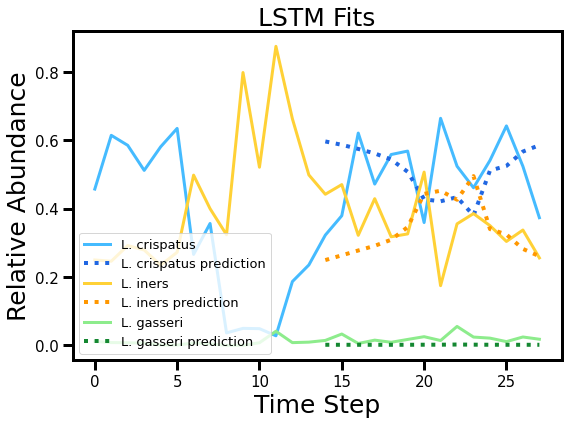

In [7]:
base_data_color = ['#2167E2', '#FF9700', '#148731']
pred_color = ['#45BBFF', '#FFD136', '#8DEC8C']
best_fit_idx = [0, 1, 3]
full_test_data = torch.concat((torch.clone(tensor_true_test_in),torch.clone(tensor_true_test_data)))
plot_best_fit(full_test_data, best_prediction, pred_color, base_data_color, best_fit_idx, blastT_labels, False, None)

##Calculating SHAP Values
Calculates SHAP values across the entire training set.

In [8]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 8.6 MB/s 


In [9]:
import shap
copy_model = copy.deepcopy(best_model.eval())
_, shap_values = shap_val(copy_model, trainingData, None)
all_shap_val = np.array(shap_values)
print('Shap Values Size:', all_shap_val.shape)   #Shape (Outputs, input shape)

RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Shap Values Size: (15, 413, 14, 15)


##Plotting the SHAP values
This defines the function and helper functions to plot the SHAP values using matplotlib to uncover insights into microbial community interactions. 

In [10]:
def top_shap_feature_selection(all_shap_values, num_exp_features, feature_output_idx):
    assert str(type(all_shap_values)) == "<class 'list'>" or str(type(all_shap_values)) == "<class 'numpy.ndarray'>"

    if type(all_shap_values) == list:
        all_shap_values = np.array(all_shap_values)
    
    shap_shape = all_shap_values.shape
    
    all_shap_values = np.mean(np.abs(all_shap_val)[feature_output_idx], axis=0)
    mean_absolute_val_shap = all_shap_values.copy()
    idx = np.argsort(all_shap_values.flatten())[::-1][0:int(num_exp_features)]
    
    flat_shap = all_shap_values.flatten()
    idxT_step = (np.divide(idx, shap_shape[-1]))
    idxFeature = idx % shap_shape[-1]
    mean_absolute_val_shap = mean_absolute_val_shap.flatten()
    return idx.astype('int64'), idxT_step.astype('int64'), idxFeature.astype('int64'), mean_absolute_val_shap[idx]
    
def budget_beeswarm(all_shap_values, input_data, num_exp_features, labels, feature_output_idx, path, colorbar=True, title=False):
    #all_shap_values should be a ndarray or list of ndarrays of shape (#outputs, #samples, #timesteps, #input features)
    #input_data expects a numpy array of the inputs to the model of shape (#samples, #timesteps, #input features)
    #labels is a list of the labels, ex. blastT_labels
    #num_exp_features is an integer, the number of output features wanted to explain the desired output feature (using the num_exp_features with sorting by absolute value average shap value score)
    #feature_output_idx is the index of the desired feature output from the outputs of the model, in this case 0 to 14 for each species
    #path is the folder saving path, if it is None, then it is not saved
    assert str(type(all_shap_values)) == "<class 'list'>" or str(type(all_shap_values)) == "<class 'numpy.ndarray'>"
    assert str(type(input_data)) == "<class 'numpy.ndarray'>"
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rcParams['axes.linewidth'] = 3
    if type(all_shap_values) == list:
        all_shap_values = np.array(all_shap_values)
    
    shap_shape = all_shap_values.shape
    num_total_values = int(shap_shape[0] * shap_shape[1] * shap_shape[2] * shap_shape[3])
    fig, ax = plt.subplots()

    assert len(shap_shape) == 4
    assert shap_shape[2] == input_data.shape[1]
    
    idx, idxT_step, idx_Feature, MAV_Shap = top_shap_feature_selection(all_shap_values, num_exp_features, feature_output_idx)
    
    #Shap Values to be plotted on x axis
    rx = all_shap_values[feature_output_idx, :, idxT_step, idx_Feature].flatten()
    cx = input_data[:, idxT_step, idx_Feature].flatten()
    
    #Color bar min, max, feature data to color by, and red to blue coloring setup
    rvmin = np.min(input_data)
    rvmax = np.max(input_data)
    vcenter = np.mean(cx[idx])

    if vcenter <= rvmin:
        vcenter = 0.5
        rvmin = 0.0
    normalize = mcol.TwoSlopeNorm(vcenter=vcenter, vmin=rvmin, vmax=rvmax)
    if colorbar:
        colormap = cm.coolwarm_r
    else:
        color = mcol.ListedColormap(['#AC62FF', '#AC62FF'])
    #y axis timestep plotting
    timestepY = np.array(range(num_exp_features)) + 1

    ry = np.tile(timestepY, int(shap_shape[1])).flatten()

    #Plotting
    sc = plt.scatter(rx, ry, c=cx, vmin=rvmin, vmax=rvmax, s=4, cmap=colormap)
    pts = ax.collections[0]
    pts.set_offsets(pts.get_offsets() + np.c_[np.zeros(cx.shape[0]), np.random.uniform(-.3, .3, cx.shape[0])])
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(cx)
    fig.colorbar(scalarmappaple)

    plt.ylabel('Top ' + str(num_exp_features) + ' Impact Features', fontsize=25)
    plt.xlabel('Shap Values', fontsize=25)

    features = np.char.add(np.array(labels)[idx_Feature.astype('int64')], np.char.add(np.char.add(' (t=', (idxT_step + 1).astype('str')), ')'))

    ax.set_yticks(list(range(1, num_exp_features+1)))
    ax.set_yticklabels(features)
    ax.tick_params('both', length=10, width=3)

    _ymin = np.array(range(1, num_exp_features + 1)) - 0.4
    _ymax = np.array(range(1, num_exp_features + 1)) + 0.4
    plt.vlines(x=MAV_Shap, ymin=_ymin, ymax=_ymax, colors='green')

    if colorbar:
        fig.set_label('Feature Value')
    if title:
        plt.title('Explaining ' + str(labels[feature_output_idx]))
    plt.tight_layout()
    if path is not None:
        plt.savefig(path)
    plt.show()




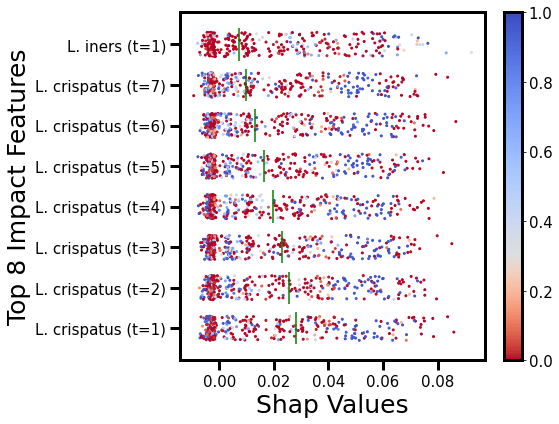

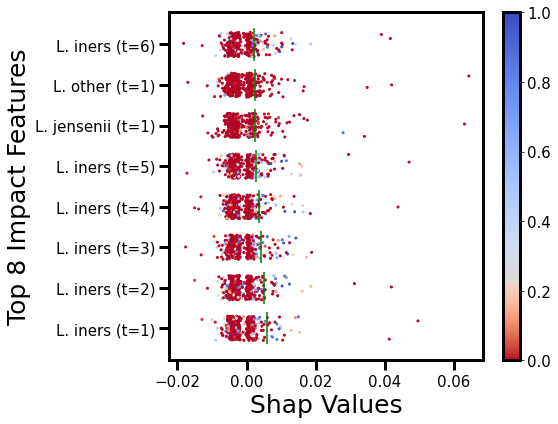

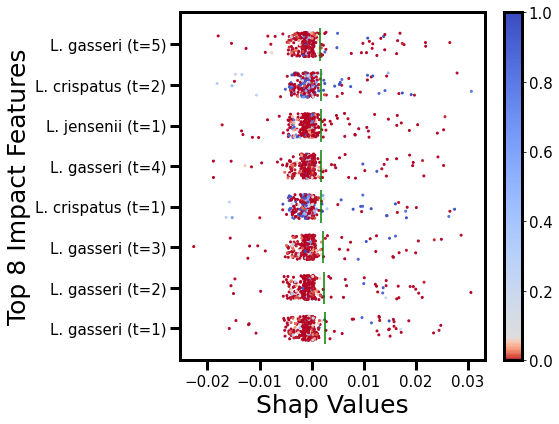

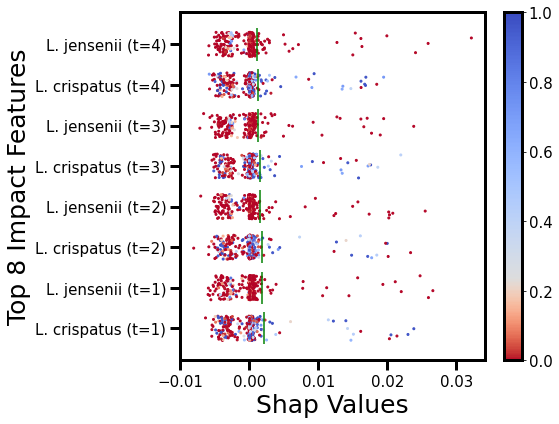

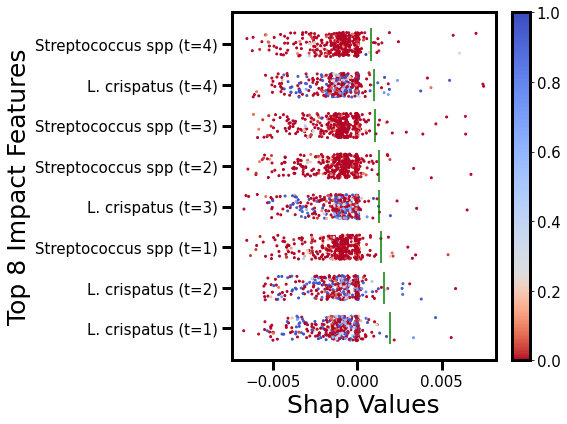

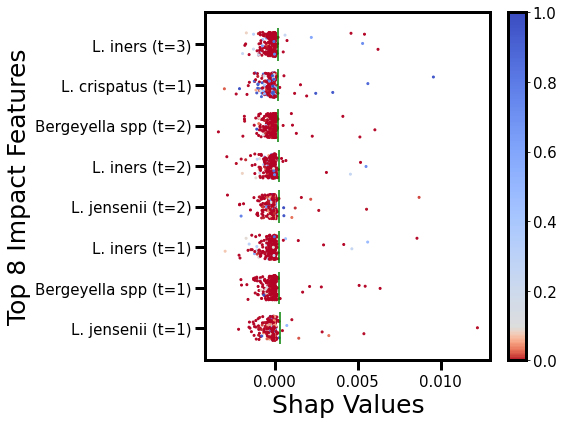

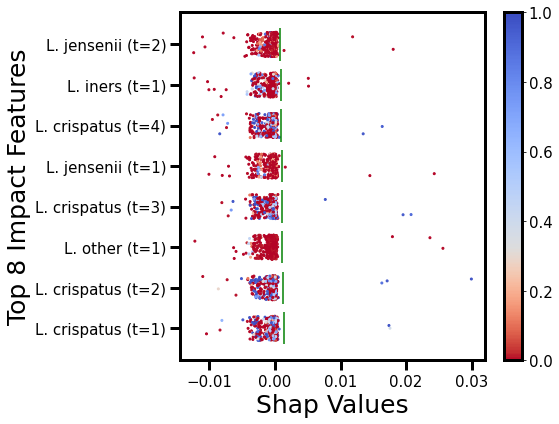

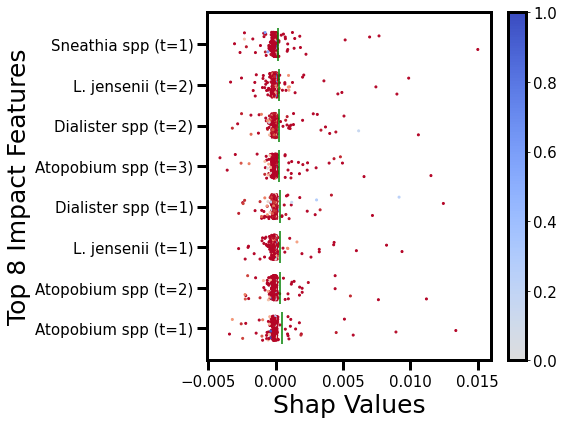

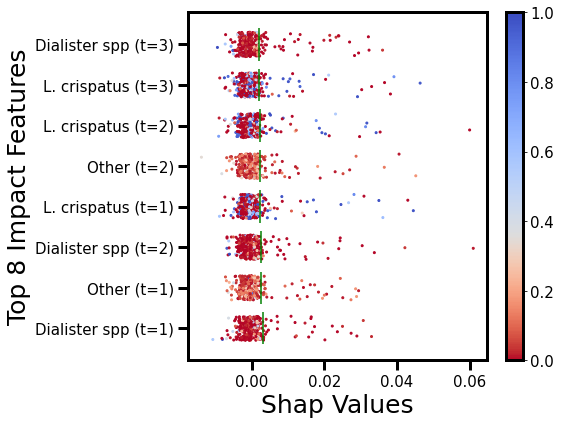

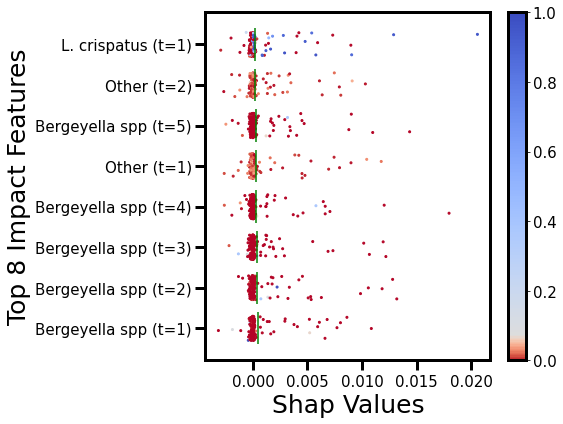

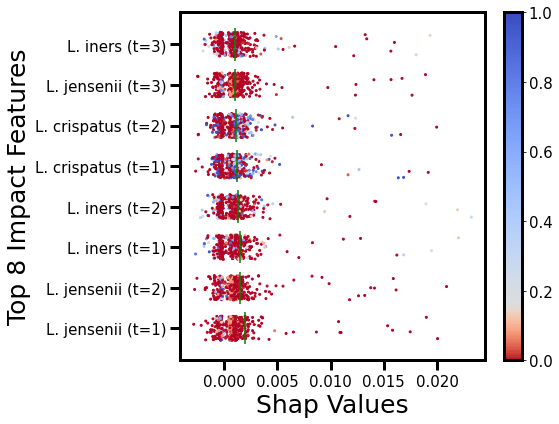

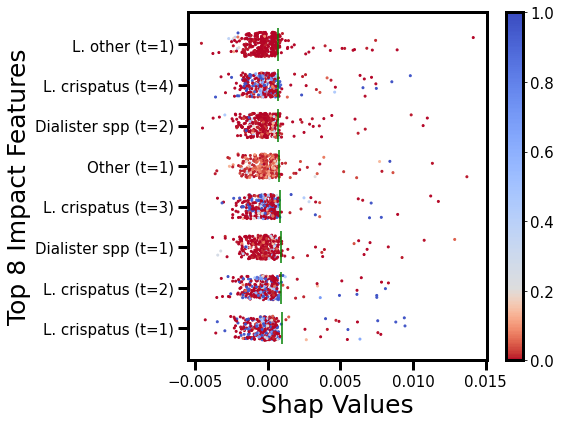

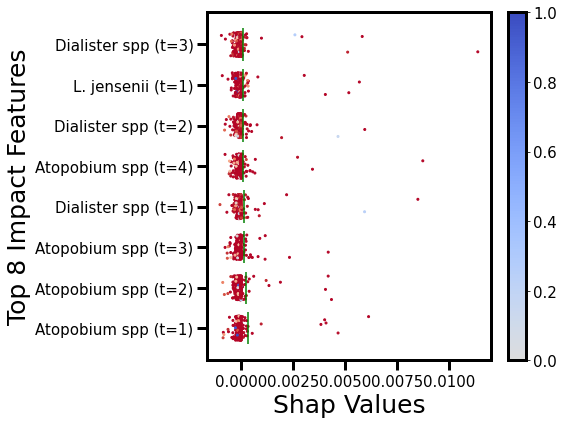

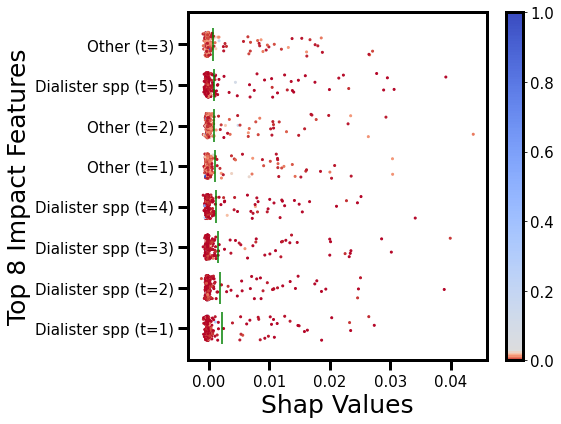

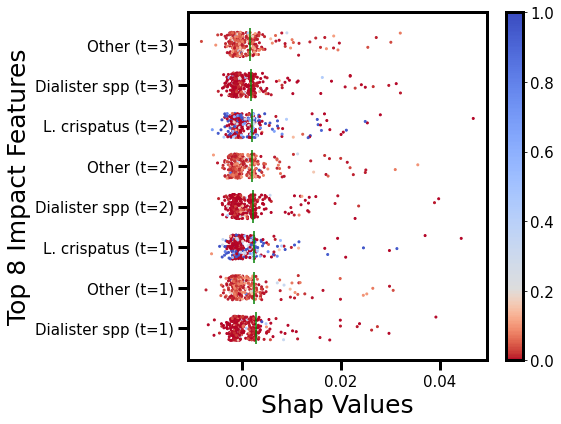

In [11]:
for idx in range(15):
    path=None
    budget_beeswarm(all_shap_val, trainingData.numpy(), 8, blastT_labels, idx, path)